# Common import and setup


In [1]:
import os, sys, time, pytest

import matplotlib.pyplot as plt
from matplotlib import patches, lines
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import pdfminer

from IPython.display import display

# Make sure we use the local version of camelot if it is here
sys.path.insert(0, os.path.abspath(''))

import camelot
from camelot.core import Table, TableList, TextEdges
from camelot.__version__ import generate_version
from camelot.utils import get_text_objects, text_in_bbox
from camelot.parsers.stream import Stream
from camelot.parsers.hybrid import Hybrid
from camelot.handlers import PDFHandler
from camelot.plotting import draw_pdf
from tests.data import *

testdir = os.path.dirname(os.path.abspath('.'))
testdir = os.path.join(testdir, "camelot/tests/files")

# To check which library we're using
camelot.__file__


'/Users/francoishuet/Code/camelot/camelot/__init__.py'

In [2]:
kwargs = {}
data = None
# pdf_file = "vertical_header.pdf"
# pdf_file, kwargs, data = "superscript.pdf", {"flag_size": True}, data_stream_flag_size # test_hybrid_flag_size
# pdf_file = "health.pdf"  # test_hybrid
# pdf_file = "clockwise_table_2.pdf"
# pdf_file = "tabula/12s0324.pdf" # interesting because contains two separate tables
# pdf_file = "clockwise_table_2.pdf"  # test_hybrid_table_rotated / test_stream_table_rotated
# pdf_file, kwargs = "tabula/us-007.pdf", {"table_regions": ["320,335,573,505"]} # test_hybrid_table_regions
# pdf_file, kwargs = "detect_vertical_false.pdf", {"strip_text": " ,\n"}  # data_stream_strip_text
# pdf_file, kwargs, data = "tabula/m27.pdf", {"columns": ["72,95,209,327,442,529,566,606,683"], "split_text": True, }, data_stream_split_text  # data_stream_split_text
pdf_file = "vertical_header.pdf"
# pdf_file = "twotables_2.pdf"
# pdf_file = "camelot-issue-132-multiple-tables.pdf"
# pdf_file, kwargs, data = "edge_tol.pdf", {"edge_tol": 500}, data_stream_edge_tol
# pdf_file, kwargs, data = "edge_tol.pdf", {}, data_stream_edge_tol
# pdf_file, kwargs = "tabula/icdar2013-dataset/competition-dataset-us/us-030.pdf", {"pages": "2"}  # test_lattice
# pdf_file, kwargs = "background_lines_1.pdf", {} # {"process_background": True}  # test_lattice_process_background

filename = os.path.join(testdir, pdf_file)

Showing table #0 found by stream:


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,Alcona,963,439,Brian Calley\n55,Patrick Colbeck\n26,Jim Hines\n47,Bill Schuette\n164,John James\n173,Sandy Pensler\n111,,...,,Al Scully\n271,,Daniel G. Gauthier\n224,Craig M. Clemens\n76,Craig Johnston,,Adam Brege,David Bielusiak,
1,Caledonia,923,393,40,23,45,158,150,103,,...,,244,,139,143,,,,,
2,Curtis,1026,349,30,30,25,102,95,84,,...,,157,,,,,,,,
3,Greenbush,1212,423,56,26,40,126,104,131,,...,,208,,,,,208,,,
4,Gustin,611,180,22,35,17,55,73,45,,...,,109,,,,,,81,42,
5,Harrisville,1142,430,45,90,29,101,155,94,,...,,226,,,,232,,,,
6,Hawes,884,293,38,36,27,109,121,84,,...,,184,,,,,,118,87,
7,Haynes,626,275,31,20,32,104,121,53,,...,,152,,,,76,,69,31,
8,Mikado,781,208,19,39,17,81,90,63,,...,,143,,,,,113,,,
9,Millen,353,139,7,16,13,38,49,19,,...,,62,,,,,,,,


Showing table #0 found by lattice:


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,,,STATE,,,,CONGRESSIONAL,,,,...,,COUNTY,,County Commissioner,,,,,,
1,,,Governor,,,,U.S. Senator,,,Congress-\n1st Dist,...,,Road \nCommission,,District #1,,Distri\nct #2,Dist \n#3,Dist #4,,Dist \n#5
2,Number of Registered voters,Poll Book Totals,Brian Calley,Patrick Colbeck,Jim Hines,Bill Schuette,John James,Sandy Pensler,,Jack Bergman,...,,Al Scully,,Daniel G. Gauthier,Craig M. Clemens,Craig Johnston,Carolyn Brummund,Adam Brege,David Bielusiak,
3,963,439,55,26,47,164,173,111,,268,...,,271,,224,76,,,,,
4,,,,,,,,,,,...,,,,,,,,,,
5,923,393,40\n23\n45\n158,,,,150\n103,,,244,...,,244,,139,143,,,,,
6,,,,,,,,,,,...,,,,,,,,,,
7,1026,349,30\n30\n25\n102,,,,95\n84,,,159,...,,157,,,,,,,,
8,,,,,,,,,,,...,,,,,,,,,,
9,1212,423,56\n26\n40\n126,,,,104\n131,,,208,...,,208,,,,,208,,,


Showing table #0 found by hybrid:


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,,,,,,,,,,,...,,Reg. of,Road,,,,Distri,Dist,,
1,,,,,,,,,,,...,,Deeds,,Commission,,District #1,ct #2,#3,,Dist #4
2,,,,,,Governor,,,U.S. Senator,,...,,,,,,,,,,
3,,Number of Registered voters,Poll Book Totals,Brian Calley,Patrick Colbeck,Jim Hines,Bill Schuette,John James,Sandy Pensler,,...,Melissa A. Cordes,,Al Scully,,Daniel G. Gauthier,Craig M. Clemens,Craig Johnston,Carolyn Brummund,Adam Brege,David Bielusiak
4,Alcona,963,439,55,26,47,164,173,111,,...,269,,271,,224,76,,,,
5,Caledonia,923,393,40,23,45,158,150,103,,...,255,,244,,139,143,,,,
6,Curtis,1026,349,30,30,25,102,95,84,,...,161,,157,,,,,,,
7,Greenbush,1212,423,56,26,40,126,104,131,,...,215,,208,,,,,208,,
8,Gustin,611,180,22,35,17,55,73,45,,...,111,,109,,,,,,81,42
9,Harrisville,1142,430,45,90,29,101,155,94,,...,244,,226,,,,232,,,


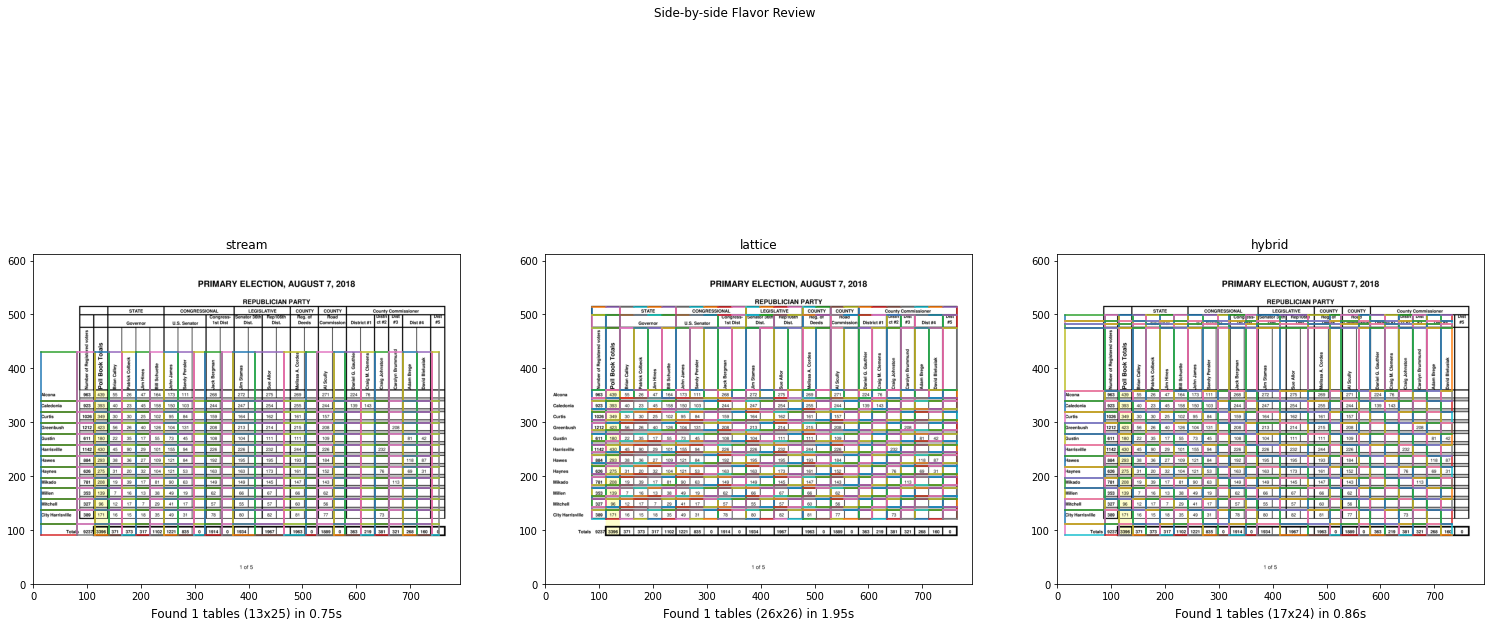

In [3]:

# Set up plots to be large enough for visualization
plt.rcParams["figure.figsize"] = [26, 12]
fig, axes = plt.subplots(1, 3)
fig.suptitle('Side-by-side Flavor Review')
tables_list = []
for idx, flavor in enumerate(["stream", "lattice", "hybrid"]):
    timer_before_parse = time.perf_counter()
    tables = camelot.read_pdf(filename, flavor=flavor, debug=True, **kwargs)
    tables_list.append(tables)
    timer_after_parse = time.perf_counter()
    ax = axes[idx]
    for idx_table, table in enumerate(tables):
        print("Showing table #{idx} found by {flavor}:".format(idx=idx_table, flavor=flavor))
        display(table.df)
        fig = camelot.plot(table, kind='grid', ax=ax)
    ax.set_title("{flavor}".format(flavor=flavor))
    tables_dims = ", ".join(
        map(
            lambda table: "{rows}x{cols}".format(
                rows=table.shape[0],
                cols=table.shape[1],
            ), tables
        )
    )
    ax.text(
        0.5,-0.1, 
        "Found {table_num} tables ({tables_dims}) in {parse_time:.2f}s".format(
            table_num=len(tables),
            tables_dims=tables_dims,
            parse_time=timer_after_parse - timer_before_parse,
        ), 
        size=12, ha="center", 
        transform=ax.transAxes
    )
    timer_after_plot = time.perf_counter()
fig